# RSF Gym Traffic: Best Times by Day of Week

This notebook loads `scraped_data2.csv`, aggregates occupancy by weekday and time of day, visualizes it, and suggests recommended low-traffic windows.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")


In [2]:
# Load data
csv_path = "scraped_data2.csv"
df = pd.read_csv(csv_path, parse_dates=["Timestamp"])
print(df)
# Basic cleaning
df = pd.read_csv(csv_path, parse_dates=["Timestamp"])
df.columns = df.columns.str.strip()
df["percent_filled"] = pd.to_numeric(df["percent_filled"], errors="coerce")
df = df.dropna(subset=["percent_filled"]).sort_values("Timestamp").reset_index(drop=True)

df.head()


               Timestamp   percent_filled
0    2023-02-13 12:38:00             1.03
1    2023-02-13 12:40:00             1.00
2    2023-02-13 12:43:00             0.98
3    2023-02-13 12:45:00             0.98
4    2023-02-13 12:48:00             1.00
...                  ...              ...
7475 2023-03-29 19:45:00             0.41
7476 2023-03-29 19:50:00             0.40
7477 2023-03-29 19:55:00             0.36
7478 2023-03-29 20:00:00             0.35
7479 2023-03-29 20:05:00             0.32

[7480 rows x 2 columns]


,Timestamp,percent_filled
0,2023-02-13 12:38:00,1.03
1,2023-02-13 12:40:00,1.00
2,2023-02-13 12:43:00,0.98
3,2023-02-13 12:45:00,0.98
4,2023-02-13 12:48:00,1.00


In [3]:
# Filter to gym open hours
from datetime import time


def is_open(ts):
    wd = ts.weekday()  # Monday=0 ... Sunday=6
    t = ts.time()
    if wd == 5:  # Saturday
        return time(8, 0) <= t < time(18, 0)
    elif wd == 6:  # Sunday
        return time(8, 0) <= t < time(23, 0)
    else:  # Monday-Friday
        return time(7, 0) <= t < time(23, 0)


df = df[df["Timestamp"].apply(is_open)].reset_index(drop=True)


In [4]:
# Feature engineering: weekday and 15-min time bins
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

df["weekday"] = df["Timestamp"].dt.day_name()
df["weekday"] = pd.Categorical(df["weekday"], categories=weekday_order, ordered=True)

# 15-minute bins (time-of-day only)
df["time_bin"] = df["Timestamp"].dt.floor("15min")
df["time_str"] = df["time_bin"].dt.strftime("%H:%M")

# Aggregation key for plotting order
# Convert HH:MM to timedelta to sort and to minutes for numeric axis
sort_td = pd.to_timedelta(df["time_str"] + ":00")
df["minutes"] = (sort_td.dt.total_seconds() // 60).astype(int)

df.head()


,Timestamp,percent_filled,weekday,time_bin,time_str,minutes
0,2023-02-13 12:38:00,1.03,Monday,2023-02-13 12:30:00,12:30,750
1,2023-02-13 12:40:00,1.00,Monday,2023-02-13 12:30:00,12:30,750
2,2023-02-13 12:43:00,0.98,Monday,2023-02-13 12:30:00,12:30,750
3,2023-02-13 12:45:00,0.98,Monday,2023-02-13 12:45:00,12:45,765
4,2023-02-13 12:48:00,1.00,Monday,2023-02-13 12:45:00,12:45,765


In [5]:
# Aggregate average occupancy by weekday and time-of-day (15-min bins)
agg = (df.groupby(["weekday", "time_str", "minutes"], observed=True)["percent_filled"]
         .mean()
         .rename("avg_fill")
         .reset_index())

# Prepare pivot for heatmap (columns sorted by time)
cols_sorted = sorted(agg["time_str"].unique(), key=lambda s: pd.to_timedelta(s+":00"))
pivot = (agg.pivot(index="weekday", columns="time_str", values="avg_fill")[cols_sorted])

agg.head()


,weekday,time_str,minutes,avg_fill
0,Monday,07:00,420,0.244167
1,Monday,07:15,435,0.532500
2,Monday,07:30,450,0.683333
3,Monday,07:45,465,0.677500
4,Monday,08:00,480,0.708182


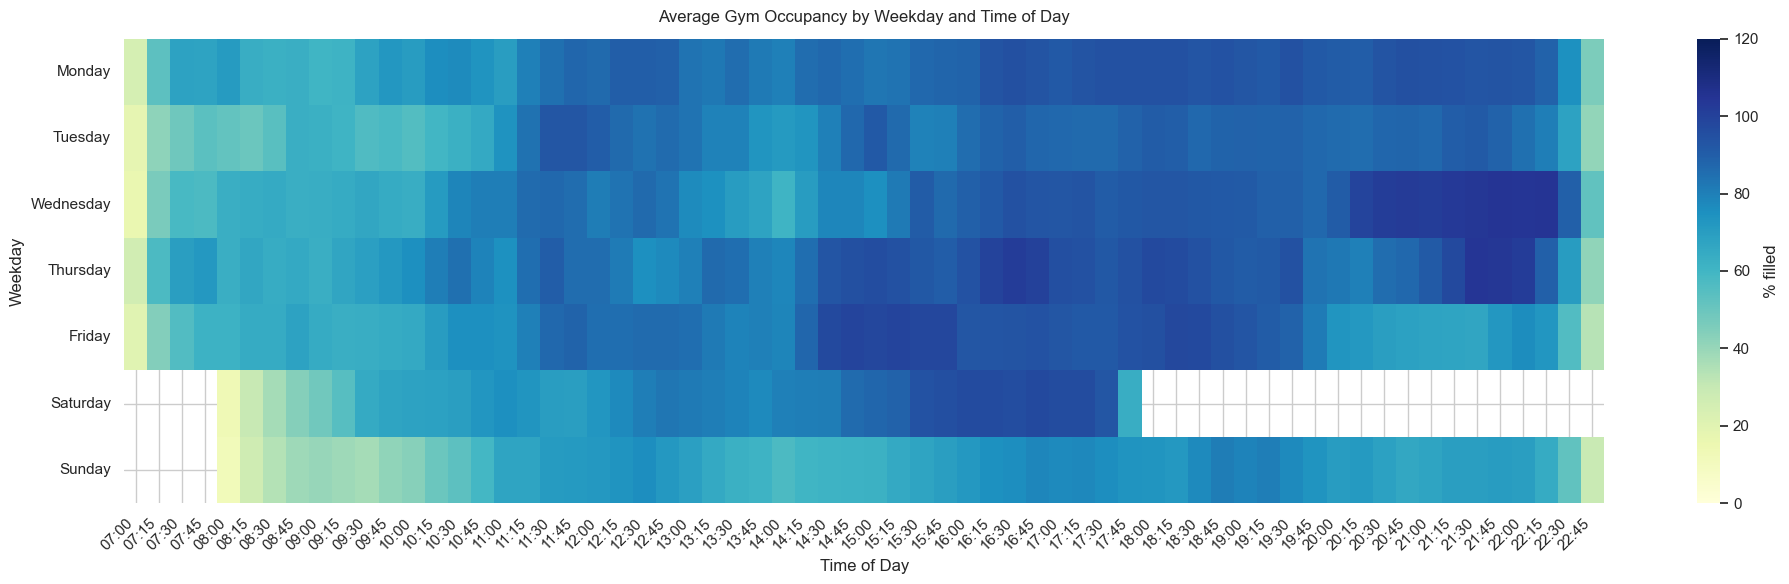

In [6]:
# Heatmap: Average % filled by weekday and time of day
plt.figure(figsize=(20, 6))
ax = sns.heatmap(pivot * 100, cmap="YlGnBu", vmin=0, vmax=120,
                 cbar_kws={"label": "% filled"})
ax.set_title("Average Gym Occupancy by Weekday and Time of Day", pad=12)
ax.set_xlabel("Time of Day")
ax.set_ylabel("Weekday")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


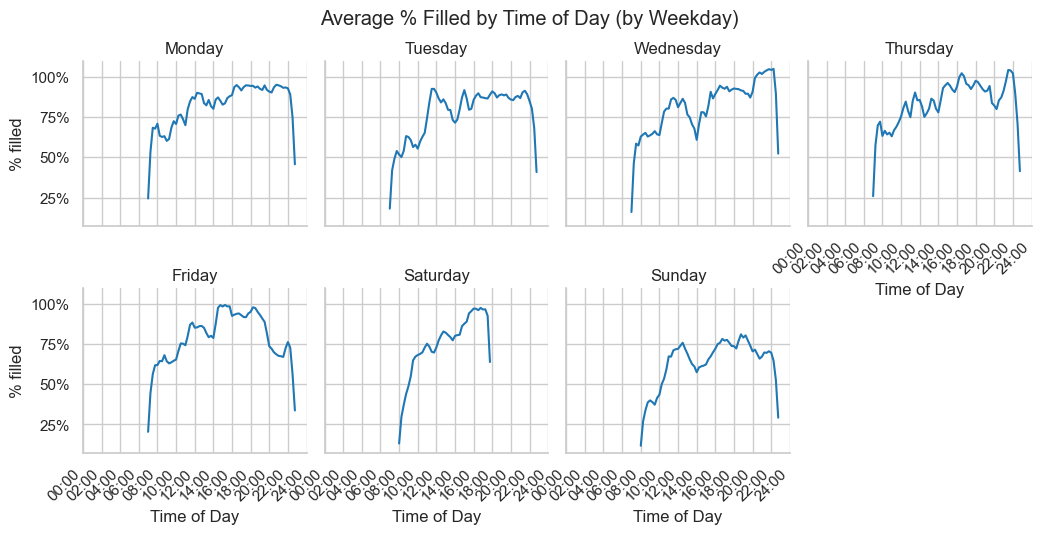

In [7]:
# Per-weekday time series (15-min resolution)
# Use minutes since midnight for x-axis and format ticks as HH:MM

g = sns.FacetGrid(agg, col="weekday", col_wrap=4, height=2.6, sharex=True, sharey=True)
g.map(sns.lineplot, "minutes", "avg_fill", color="#1f77b4")

for ax in g.axes.flatten():
    ax.set_xlim(0, 24 * 60)
    ax.set_xticks(range(0, 24 * 60 + 1, 120))  # every 2 hours
    ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 25, 2)], rotation=45, ha="right")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("% filled")

g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.88)
g.fig.suptitle("Average % Filled by Time of Day (by Weekday)")
plt.show()


In [8]:
# Recommend low-traffic windows (per weekday)
# Criterion: times at or below the 25th percentile for that weekday,
# with contiguous windows of at least 30 minutes (>= 2 consecutive 15-min bins)

recommendations = {}
for weekday, sub in agg.groupby("weekday"):
    if sub.empty:
        continue
    q25 = sub["avg_fill"].quantile(0.25)
    # Cap threshold at 50% to avoid suggesting overly crowded times if distribution is flat
    thr = min(q25, 0.50)

    sub = sub.sort_values("minutes").reset_index(drop=True)
    sub["is_low"] = sub["avg_fill"] <= thr

    intervals = []
    start = None
    prev = None
    for _, row in sub.iterrows():
        if row["is_low"]:
            if start is None:
                start = row["minutes"]
            prev = row["minutes"]
        else:
            if start is not None:
                intervals.append((start, prev))
                start = None
                prev = None
    if start is not None:
        intervals.append((start, prev))

    # Keep intervals lasting at least 30 minutes
    filtered = [(s, e) for (s, e) in intervals if (e - s) >= 30]
    recommendations[weekday] = {"threshold": thr, "intervals": filtered}

# Pretty print recommendations

def fmt_time(mins):
    h = int(mins // 60)
    m = int(mins % 60)
    return f"{h:02d}:{m:02d}"

for weekday in recommendations:
    info = recommendations[weekday]
    thr = info["threshold"]
    print(f"{weekday}: recommended windows (<= {thr:.0%} filled)")
    if not info["intervals"]:
        print("  - No low-traffic windows ≥ 30 minutes found")
    for (s, e) in info["intervals"]:
        # add 15 minutes to the end to include the last bin in the printable range
        print(f"  - {fmt_time(s)} to {fmt_time(e + 15)}")


Monday: recommended windows (<= 50% filled)
  - No low-traffic windows ≥ 30 minutes found
Tuesday: recommended windows (<= 50% filled)
  - 07:00 to 07:45
Wednesday: recommended windows (<= 50% filled)
  - No low-traffic windows ≥ 30 minutes found
Thursday: recommended windows (<= 50% filled)
  - No low-traffic windows ≥ 30 minutes found
Friday: recommended windows (<= 50% filled)
  - No low-traffic windows ≥ 30 minutes found
Saturday: recommended windows (<= 50% filled)
  - 08:00 to 09:15
Sunday: recommended windows (<= 50% filled)
  - 08:00 to 10:30
